<a href="https://colab.research.google.com/github/A-Wadhwani/ME597-Project/blob/main/ANN_Model_UMass_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [53]:
#importing required libraries
%load_ext tensorboard
import tensorflow as tf
import keras as kr
import numpy as np
import pandas as pd
import datetime
import statistics as st
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras import regularizers


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
#Importing the dataset

data_df = pd.read_csv("https://raw.githubusercontent.com/A-Wadhwani/ME597-Project/main/Datasets/Umass_total_data2.csv")
data_df.head(10)


,Unnamed: 0,Year,Month,Day,DHI,DNI Max,DNI Min,DNI,GHI,Clearsky DHI,Clearsky DNI,Clearsky GHI,Wind Speed,Precipitable Water,Wind Direction,Relative Humidity,Temperature,Pressure,UMASS Amherst - Computer Science null,UMASS Amherst - Fine Arts Center null,UMASS Amherst - Recreation Center null,Date
0,0,2017,2,3,76.100000,808,194,606.200000,305.800000,86.300000,697.200000,350.800000,0.480000,0.383400,277.570000,67.023000,-3.500000,1000.000000,1.061948,1.411040,1.095000,2017-02-03
1,1,2017,2,4,88.100000,874,286,676.200000,345.400000,88.200000,694.800000,355.100000,0.600000,0.363900,284.940000,67.680000,-3.900000,1000.000000,1.409026,1.852061,1.453818,2017-02-04
2,2,2017,2,5,122.888889,693,31,356.222222,278.333333,117.666667,615.888889,370.555556,0.566667,0.886000,209.822222,76.916667,-1.000000,992.222222,0.810475,0.826453,0.818667,2017-02-05
3,3,2017,2,6,77.666667,927,4,649.222222,336.444444,72.222222,752.111111,373.000000,0.611111,0.731889,294.100000,61.147778,-1.777778,1000.000000,1.234228,1.570186,1.250591,2017-02-06
4,4,2017,2,8,109.800000,850,33,466.400000,295.700000,96.600000,657.000000,360.400000,0.500000,1.026600,284.440000,98.111000,2.800000,985.000000,0.657363,1.043031,0.712076,2017-02-08
5,5,2017,2,10,97.700000,969,213,648.100000,347.400000,75.300000,799.600000,395.800000,0.800000,0.313100,303.320000,79.364000,-9.400000,1000.000000,0.630855,0.915967,0.251333,2017-02-10
6,6,2017,2,11,231.333333,71,44,60.000000,263.666667,174.333333,717.000000,559.333333,0.100000,1.254333,93.700000,93.980000,-2.000000,990.000000,0.013872,0.314078,0.006076,2017-02-11
7,7,2017,2,13,151.100000,634,54,364.500000,288.500000,134.700000,593.500000,384.800000,1.310000,0.568900,313.540000,91.813000,-4.100000,984.000000,0.021354,1.335474,0.008955,2017-02-13
8,8,2017,2,14,88.300000,907,269,715.200000,395.300000,86.300000,756.600000,402.000000,0.280000,0.607600,262.120000,88.257000,-3.300000,990.000000,0.177933,1.911908,0.117985,2017-02-14
9,9,2017,2,15,173.875000,457,7,231.000000,281.375000,151.500000,602.375000,438.750000,0.237500,1.008250,145.400000,99.466250,0.750000,975.000000,0.253753,0.659790,0.230424,2017-02-15


In [55]:
data_df.dtypes

Unnamed: 0                                  int64
Year                                        int64
Month                                       int64
Day                                         int64
DHI                                       float64
DNI Max                                     int64
DNI Min                                     int64
DNI                                       float64
GHI                                       float64
Clearsky DHI                              float64
Clearsky DNI                              float64
Clearsky GHI                              float64
Wind Speed                                float64
Precipitable Water                        float64
Wind Direction                            float64
Relative Humidity                         float64
Temperature                               float64
Pressure                                  float64
UMASS Amherst - Computer Science null     float64
UMASS Amherst - Fine Arts Center null     float64


# Data Sorting and scaling

In [56]:
#Splitting dataset into X and Y variables
X_data = data_df[['DHI','DNI Max', 'DNI Min', 'DHI', 'GHI', 'Clearsky DNI', 'Clearsky DHI', 'Clearsky GHI', 'Wind Speed', 'Precipitable Water', 'Wind Direction', 'Relative Humidity', 'Temperature', 'Pressure']]
Y_data = data_df[['UMASS Amherst - Fine Arts Center null']]

In [57]:
#Scaling the data
scaler1 = RobustScaler()
scaler2 = RobustScaler()

X_data_scaled = scaler1.fit_transform(X_data)
Y_data_scaled = scaler2.fit_transform(Y_data)

In [58]:
#Splitting the X and Y variables into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.25)

# Developing ANN model

In [59]:
#creating optimizer method
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.8, beta_2=0.999, epsilon=1e-8)

In [ ]:
# Creating and training the ANN model
model = Sequential()
model.add(Dense(512, input_dim = X_data.shape[1], activation='relu', kernel_initializer = 'random_normal'))
model.add(Dense(256, activation='relu', kernel_initializer = 'random_normal',  activity_regularizer=regularizers.l1(3.5e-4)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_initializer = 'random_normal',  activity_regularizer=regularizers.l1(3.5e-4)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_initializer = 'random_normal',  activity_regularizer=regularizers.l1(3.5e-4)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer = 'random_normal',  activity_regularizer=regularizers.l1(3.5e-4)))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu', kernel_initializer = 'random_normal',  activity_regularizer=regularizers.l1(3.5e-4)))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mae', optimizer = optimizer1, metrics = ['mean_squared_error','mae'])


monitor = EarlyStopping(monitor ='val_loss', min_delta= 1e-3, patience = 50, verbose =1, restore_best_weights=True  )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose = 1)

history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 200, verbose =1, callbacks = [monitor, reduce_lr], batch_size = 15)

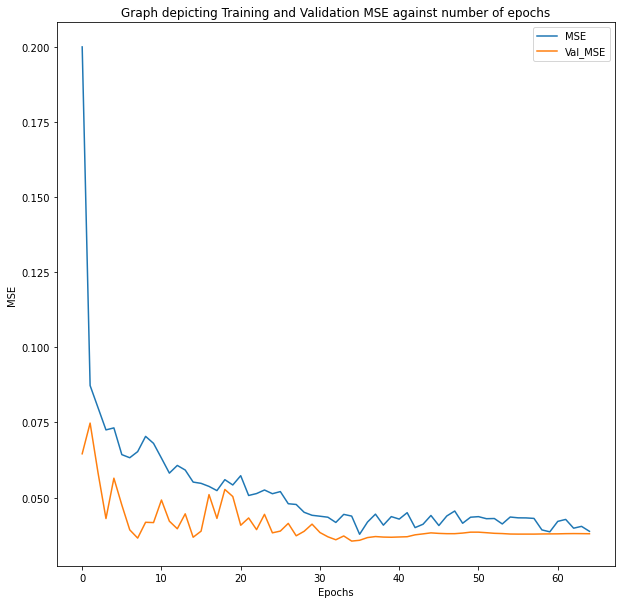

In [61]:
plt.figure(figsize= (10,10))
plt.plot(history.history['mean_squared_error'],label='MSE')
plt.plot(history.history['val_mean_squared_error'],label='Val_MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title("Graph depicting Training and Validation MSE against number of epochs")
plt.legend()

# Analyzing effectiveness of model

In [62]:
y_f_result = model.predict(X_test)
y_result = scaler2.inverse_transform(y_f_result)
y_actual = scaler2.inverse_transform(Y_test)

compare = pd.DataFrame()
compare['Expected'] = y_actual.reshape(1,-1)[0]
compare['Result'] = y_result.reshape(1,-1)[0]
compare['Difference'] = compare['Expected'] - compare['Result']
compare['Percentage Error'] = 100 * compare['Difference']/compare['Expected']

#Print out percentile descriptions of model accuracy
compare['Percentage Error'].describe()

count       237.000000
mean       -607.414242
std        7174.709914
min     -103333.293939
25%          -8.366483
50%           2.418321
75%           8.886404
max         413.093329
Name: Percentage Error, dtype: float64

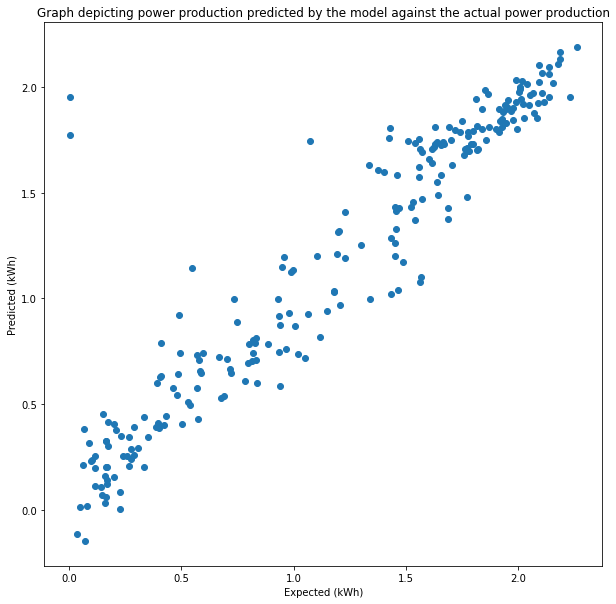

In [63]:
plt.figure(figsize= (10,10))
plt.scatter(compare['Expected'], compare['Result'])
plt.xlabel('Expected (kWh)')
plt.ylabel('Predicted (kWh)')
plt.title('Graph depicting power production predicted by the model against the actual power production')
plt.show()